# 01 - EDA, Cleaning, TF-IDF, and Logistic Regression

Steps covered here:
- Load data and build sentiment target.
- EDA: rating distribution, positive/negative split, common negative keywords, upvotes vs sentiment.
- Text preprocessing (combine + clean).
- TF-IDF feature extraction.
- Train/test split and baseline Logistic Regression.
- Evaluation (F1) and artifact saving.


In [1]:
import json
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Paths
RAW_PATH = Path("../data/raw/reviews_data.csv")
PROCESSED_PATH = Path("../data/processed/clean_reviews.csv")
MODEL_PATH = Path("../models/model.pkl")
VECTORIZER_PATH = Path("../models/vectorizer.pkl")

In [2]:
# Load data
df = pd.read_csv(RAW_PATH)

df.columns = df.columns.str.strip()
df = df.rename(columns={"Ratings": "Rating", "Review text": "Review Text"})

print(df.head())
print("\nColumns:", df.columns.tolist())
print("Rows:", len(df))


            Reviewer Name               Review Title  \
0            Kamal Suresh               Nice product   
1       Flipkart Customer     Don't waste your money   
2  A. S. Raja Srinivasan   Did not meet expectations   
3     Suresh Narayanasamy                       Fair   
4               ASHIK P A                Over priced   

               Place of Review  Up Votes  Down Votes     Month  \
0   Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1   Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2  Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3     Certified Buyer, Chennai      25.0         1.0       NaN   
4                          NaN     147.0        24.0  Apr 2016   

                                         Review Text  Rating  
0  Nice product, good quality, but price is now r...       4  
1  They didn't supplied Yonex Mavis 350. Outside ...       1  
2  Worst product. Damaged shuttlecocks packed in ...       1  
3  Quite O. K.

In [3]:
# Create sentiment target
# Positive: rating >= 4, Negative: rating <= 2; drop neutrals (rating == 3)

df = df.copy()
if "Rating" not in df.columns:
    raise ValueError("Expected 'Rating' column for sentiment creation.")

df = df[df["Rating"].notna()]

df["sentiment"] = (df["Rating"] >= 4).astype(int)
# Optionally drop neutral (3-star) rows
if (df["Rating"] == 3).any():
    df = df[df["Rating"] != 3]

df = df.reset_index(drop=True)
print(df["sentiment"].value_counts(normalize=True))


sentiment
1    0.863723
0    0.136277
Name: proportion, dtype: float64


/var/folders/kc/x_p0yhjn09n5k0crg4zv67q40000gn/T/ipykernel_33400/3089944776.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Rating", data=df, ax=axes[0], palette="Blues")
/var/folders/kc/x_p0yhjn09n5k0crg4zv67q40000gn/T/ipykernel_33400/3089944776.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sent_counts.index, y=sent_counts.values, ax=axes[1], palette=["#d62728", "#2ca02c"])


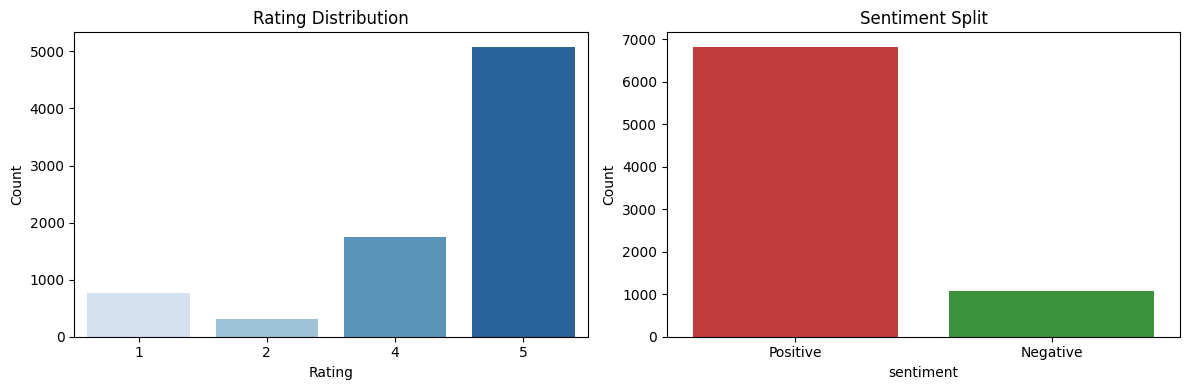

In [4]:
# EDA: rating distribution and sentiment split
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x="Rating", data=df, ax=axes[0], palette="Blues")
axes[0].set_title("Rating Distribution")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")

sent_counts = df["sentiment"].value_counts().rename({0: "Negative", 1: "Positive"})
sns.barplot(x=sent_counts.index, y=sent_counts.values, ax=axes[1], palette=["#d62728", "#2ca02c"])
axes[1].set_title("Sentiment Split")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [4]:
# Common negative keywords
neg_text = (
    df.loc[df["sentiment"] == 0, "Review Title"].fillna("") + " " +
    df.loc[df["sentiment"] == 0, "Review Text"].fillna("")
)

vectorizer = CountVectorizer(stop_words="english", ngram_range=(1, 2), max_features=30)
neg_features = vectorizer.fit_transform(neg_text)
neg_counts = np.array(neg_features.sum(axis=0)).ravel()
terms = vectorizer.get_feature_names_out()

neg_terms = pd.DataFrame({"term": terms, "count": neg_counts}).sort_values("count", ascending=False)
print(neg_terms.head(15))


           term  count
16      product    410
21         read    319
19      quality    316
8          good    229
0           bad    204
22      shuttle    200
15         poor    129
28        worst    123
23     shuttles    117
13        money    102
20  qualityread     94
4           buy     89
26        waste     85
6           don     80
9      goodread     77


/var/folders/kc/x_p0yhjn09n5k0crg4zv67q40000gn/T/ipykernel_64259/355125590.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sentiment", y="Up Votes", data=df, palette=["#d62728", "#2ca02c"])


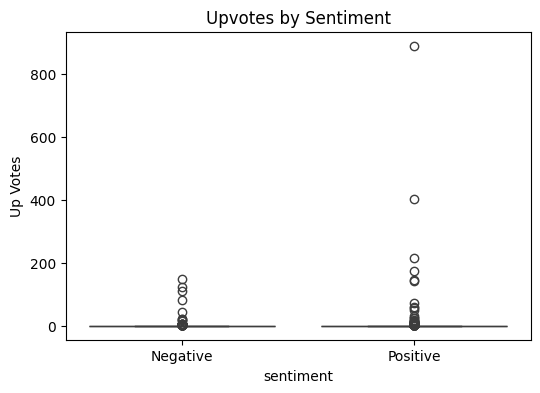

               mean  median  count
sentiment                         
0          0.643324     0.0   1071
1          0.379507     0.0   6822


In [5]:
# Upvotes vs sentiment
if "Up Votes" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="sentiment", y="Up Votes", data=df, palette=["#d62728", "#2ca02c"])
    plt.xticks([0, 1], ["Negative", "Positive"])
    plt.title("Upvotes by Sentiment")
    plt.show()

    upvote_stats = df.groupby("sentiment")["Up Votes"].agg(["mean", "median", "count"])
    print(upvote_stats)
else:
    print("Column 'Up Votes' not found; skipping this plot.")


In [6]:
# Text preprocessing: combine and clean
import re

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z ]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


df["text"] = df["Review Title"].fillna("") + " " + df["Review Text"].fillna("")
df["clean_text"] = df["text"].apply(clean_text)

# Drop rows where cleaning removed everything
before = len(df)
df = df[df["clean_text"].str.strip() != ""].reset_index(drop=True)
print(f"Dropped {before - len(df)} empty rows after cleaning")


Dropped 8 empty rows after cleaning


In [7]:
# Save cleaned data
PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(PROCESSED_PATH, index=False)
print(f"Saved cleaned data to {PROCESSED_PATH}")


Saved cleaned data to ../data/processed/clean_reviews.csv


In [8]:
# TF-IDF feature extraction
MAX_FEATURES = 5000

tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 2))
X = tfidf.fit_transform(df["clean_text"])
y = df["sentiment"].astype(int)

print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (7895, 5000)


In [9]:
# Train-test split and Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

print("Training complete")


Training complete


In [10]:
# Evaluation

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")


              precision    recall  f1-score   support

           0     0.6264    0.7757    0.6931       214
           1     0.9635    0.9275    0.9451      1365

    accuracy                         0.9069      1579
   macro avg     0.7949    0.8516    0.8191      1579
weighted avg     0.9178    0.9069    0.9110      1579

F1-score: 0.9451


In [11]:
# Save model and vectorizer
import pickle

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model, f)

with open(VECTORIZER_PATH, "wb") as f:
    pickle.dump(tfidf, f)

print(f"Saved model to {MODEL_PATH}")
print(f"Saved vectorizer to {VECTORIZER_PATH}")


Saved model to ../models/model.pkl
Saved vectorizer to ../models/vectorizer.pkl
